# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as options)

### 1.1 Get data

In [34]:
import torch as pt
import matplotlib.pyplot as plt
from torch import nn

In [35]:
# import data
from sys import path
import pandas as pd

def df_to_t(df):
    return pt.from_numpy(df.to_numpy()).type(pt.float32)

#print(f"{path[0]}\ds.csv")
DataFrame = pd.read_csv(f"{path[0]}\ds.csv")
X = df_to_t(DataFrame.iloc[:,1:3])
y = df_to_t(DataFrame.iloc[:,3:])
y = (y.squeeze())


[]

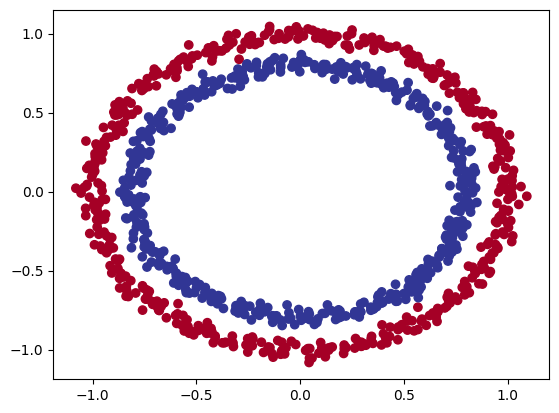

In [36]:
# visualize data
plt.scatter(X[:,0], 
            X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)
plt.plot()

In [37]:
print(X.shape, y.shape) # betyder att 2 X värdet (input) blir 1 y värde (output)

# i en grafisk mening är inputen X = (x,y)
# och y blir en ny variabel

torch.Size([1000, 2]) torch.Size([1000])


In [38]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"One sample of X: {X_sample}, one sample of y: {y_sample}")
print(f"Shape of one sample of X: {X_sample.shape}, one sample of y: {y_sample.shape}")

One sample of X: tensor([ 0.9736, -0.1748]), one sample of y: 0.0
Shape of one sample of X: torch.Size([2]), one sample of y: torch.Size([])


### 1.2 Create train and test splits

In [39]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Goal: Build a model to clarify which is blue and which is red / 0 or 1

To do so, we want to:
1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing 'nn.Module')
3. Define loss and optimizer functions
4. Create training and test loop

In [40]:
# device agnostic code
device = "cuda" if pt.cuda.is_available() else "cpu"


Construct model:
1. Subclass nn.module
2. Create 2 nn.Linear() layers that are capable of handling the shapes of our data
3. Define a forward method
4. Instatiate an instance of our model class and send it to the target device

In [41]:
from torch import nn
pt.manual_seed(42)
# Consturct the model
class CircleModelV1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #2. Create 2 nn.Linear layers
        self.Layer_1 = nn.Linear(in_features=2, out_features=5) # nu ger out_features ut 5 noder vilka sedan går in i layer_2:s in_features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # same shape as y
    
    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.Layer_1(x)) # x -> layer 1 -> layer 2 -> returned as output


In [42]:
# Instantiate an instance of our modle class
model_0 = CircleModelV1().to(device)
model_0

CircleModelV1(
  (Layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [43]:
# Let's replicate the model above using nn.Sequential(), basically en förkortning (sämre för mer komplicerade)
# pt.manual_seed(42)
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)
# print(model_0, model_0.state_dict())

Make predictions

In [44]:
with pt.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
    print(f"Length of Test samples: {len(X_test)}, Shape: {X_test.shape}")
    print()
    print(f"First 10 predictions: {pt.round(untrained_preds[:10])}")
    print(f"First 10 Test Lables: {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of Test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]])
First 10 Test Lables: tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 0.])


Loss and optimizer function 

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use now?

For regression problems you might want to use MAE or MSE (mean absolute error or mean squared error)

For classification you might want binary cross entropy or categorical cross entropy 

For this loss function we are going to use 'torch.nn.BECWithLogitsLoss()': https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

Definition of logit in deep learning: https://saturncloud.io/blog/what-is-the-meaning-of-the-word-logits-in-tensorflow/

Sigmoid activation function: https://www.learndatasci.com/glossary/sigmoid-function/


In [45]:
# Setup the loss function
#~ loss_fn = nn.BCEWithLogitsLoss() # requires inputs to have gone through the sigmoid activation function prior to input to BCELoss

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss has tha sigmoid activation function built in
 
optimizer = pt.optim.SGD(params=model_0.parameters(), lr=0.001)

In [46]:
# Calculate accuracy, how meny of the the examples the model gets right
def accuracy_fn(y_true, y_preds):
    correct = pt.eq(y_true, y_preds).sum().item()
    acc = (correct/len(y_preds)) * 100
    return acc


## 3. Train model

To train our model, we are going to need to build a training loop:

1. Forward pass
2. Calculate the loss 
3. Optimizer zero grad
4. Loss backwards (backpropagation)
5. Optimizer (gradient descent)


Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these logits into prediction probabilities by passing them through some kind to activation function (e.g sigmoid for binary cross entropy and softmax for  multpclass classification)

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the argmax

In [47]:
# View the first 5 ouputs of the forward pass on the test data
model_0.eval() # när man gör förutsägelser behöver man använda eval mode
with pt.inference_mode():
    y_logits = model_0(X_test.to(device)[:5])
    print("These are not equal and cannot be paired as one is binary and the other are floats")
    print(f"y test logits: {y_logits}")
    print(f"y test optimal: {y_test[:5]}")

These are not equal and cannot be paired as one is binary and the other are floats
y test logits: tensor([[-0.0911],
        [-0.0860],
        [-0.0895],
        [-0.1934],
        [-0.0849]])
y test optimal: tensor([1., 0., 0., 0., 0.])


In [48]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = pt.sigmoid(y_logits)
print(f"Through the sigmoid function gives: {y_pred_probs}")
print()
print(f"When rounded they render in the same binary format as with the y test")
y_preds = pt.round(y_pred_probs).squeeze()
print(y_preds)

Through the sigmoid function gives: tensor([[0.4772],
        [0.4785],
        [0.4776],
        [0.4518],
        [0.4788]])

When rounded they render in the same binary format as with the y test
tensor([0., 0., 0., 0., 0.])


For our prediction probability values, we need to perform a range-style rounding on them
* y_pred_probs >= 0.5 then y=1
* y_pred_probs < 0.5 then y=0

In [49]:
# in full, (logits -> pred probs -> pred labels)
model_0.eval()
with pt.inference_mode():
    y_preds_labels = pt.round(pt.sigmoid(model_0(X_test.to(device))))
    
    y_preds_labels = y_preds_labels.squeeze()
    print(f"{y_preds_labels}")

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


### Train and test loop

In [50]:
pt.manual_seed(42)
pt.cuda.manual_seed(42) # om man använder en gpu

# target the data to selected device
X_train,y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)


# Set the number of epochs
epochs = 100

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training:
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_preds = pt.round(pt.sigmoid(y_logits)) # logits -> pred probs -> pred labels
    
    # 2. Calculate the loss/accuracy 
    loss = loss_fn(y_logits, y_train) # eftersom den är BCEWithlogitLoss()

    acc = accuracy_fn(y_train, y_preds)

    # om den var BCELoss
    # loss_fn(pt.sigmoid(y_logits), y_train)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward (backpropagation)
    loss.backward()

    # Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with pt.inference_mode():
        # 1. forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = pt.round(pt.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_true=y_test,
                               y_preds=test_pred)
    # Print out whats happening
    if epoch%10==0:
        print(f"Epoch: {epoch}, Loss: {loss}, Acc: {acc}, Test loss: {test_loss}, Test accuracy: {test_acc:}")






Epoch: 0, Loss: 0.6960878968238831, Acc: 50.0, Test loss: 0.6956520080566406, Test accuracy: 50.0
Epoch: 10, Loss: 0.6960642337799072, Acc: 50.0, Test loss: 0.6956284046173096, Test accuracy: 50.0
Epoch: 20, Loss: 0.6960408091545105, Acc: 50.0, Test loss: 0.6956052184104919, Test accuracy: 50.0
Epoch: 30, Loss: 0.6960176229476929, Acc: 50.0, Test loss: 0.6955822110176086, Test accuracy: 50.0
Epoch: 40, Loss: 0.6959946155548096, Acc: 50.0, Test loss: 0.6955594420433044, Test accuracy: 50.0
Epoch: 50, Loss: 0.6959718465805054, Acc: 50.0, Test loss: 0.6955367922782898, Test accuracy: 50.0
Epoch: 60, Loss: 0.695949375629425, Acc: 50.0, Test loss: 0.6955145001411438, Test accuracy: 50.0
Epoch: 70, Loss: 0.6959270238876343, Acc: 50.0, Test loss: 0.6954923272132874, Test accuracy: 50.0
Epoch: 80, Loss: 0.6959049105644226, Acc: 50.0, Test loss: 0.6954705715179443, Test accuracy: 50.0
Epoch: 90, Loss: 0.6958830952644348, Acc: 50.0, Test loss: 0.6954488158226013, Test accuracy: 50.0


### 4. Make predictions and evaluate the model in a vicualization

From our metrics it looks like our model isn't learning anything

So to inspect it let's make some predictions and make them visual!

In other words, "Visualize, Visualize, Visualize!"

To do so, we're going to import a function called 'lot_decision_boundary()'


In [51]:
### Import helper functions
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper function already exists")
else:
    print("helper functions doesn't exist, download")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

helper function already exists


[]

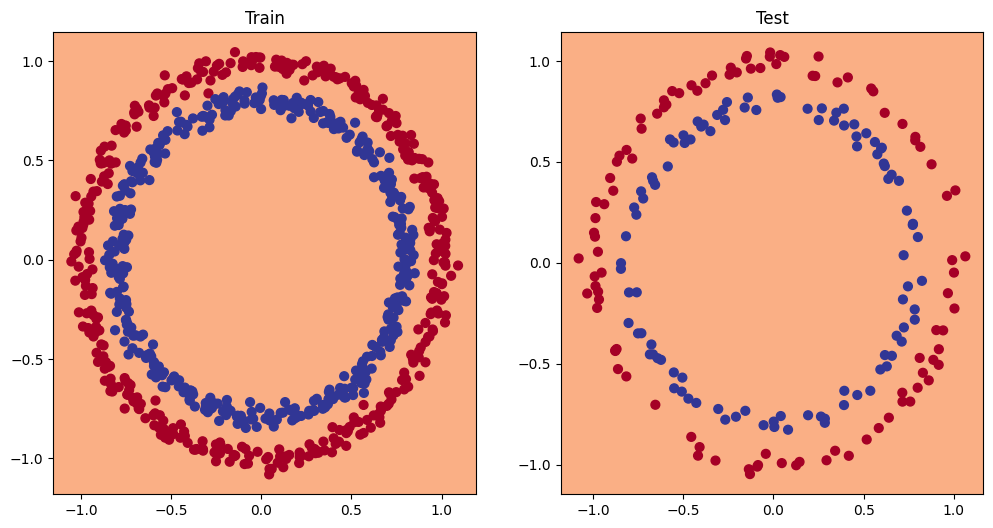

In [52]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
plt.plot()


## 5. Improving a model (from a model perspective)

#### **These values which change the functionality are called hyperparameters:**
* Add more layers - give the model more chances to learn about patterns
* Add more neurons/nodes
* Train for longer
* Change the activation function, using sigmoid rn
* Change the learning rate
* Change the loss function

#### There are also way to improve the model from a data perspective
* e.g increase the size of dataset   #e.g = example wise

Let's try to improve our model by:
* adding more hidden units/nodes: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [53]:
# When you want to find a way to improve your model, you often change one hyperparamater at a time, so you know which one may increase effectivness and which one decreases instead
pt.manual_seed(42)
class CircleModelV1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    def forward(self, x):
        # option 1, går lite fortare
        return self.layer_3(self.layer_2(self.layer_1(x)))


        # option 2:
        # layer = self.layer_1(x)
        # layer = self.layer_2(layer) # layer updateras
        # layer = self.layer_3(layer)
        # return layer
model_1 = CircleModelV1().to(device)
model_1
        



CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [54]:
print(model_1.state_dict())

OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188],
        [ 0.6146,  0.1323],
        [ 0.5224,  0.0958],
        [ 0.3410, -0.0998],
        [ 0.5451,  0.1045],
        [-0.3301,  0.1802]])), ('layer_1.bias', tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
         0.0667, -0.6984])), ('layer_2.weight', tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
          0.0346, -0.0997],
        [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
          0.1606, -0.1927],
        [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310,  0.1000, -0.0055,
          0.2475, -0.2247],
        [ 0.0199, -0.2158,  0.0975, -0.1089,  0.0969, -0.0659,  0.2623, -0.1874,
         -0.1886, -0.1886],
        [ 0.2844,  0.1054,  0.3043, -0.2610, -0.3137, -0.2474, -0.2127,  0.1281,
          0.1132,  0.26

In [55]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = pt.optim.SGD(params=model_1.parameters(), lr=0.1)

In [62]:
# Write a training and evaluation loop for model_1
pt.manual_seed(42)
pt.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
for epoch in range(epochs):
    model_1.train()
    
    y_logits = model_1(X_train).squeeze()
    y_preds = pt.round(pt.sigmoid(y_logits))

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)

    # 3 Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards (back propogation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    # Testing
    model_1.eval()
    with pt.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = pt.round(pt.sigmoid(test_logits))

        # 2. Calculate the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

        # Print out what is happening
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Loss: {loss}, Acc: {acc}, Test loss: {test_loss}, Test acc: {test_acc}%")
            
     



Epoch: 0, Loss: 0.6929889917373657, Acc: 50.375, Test loss: 0.6943044066429138, Test acc: 48.0%
Epoch: 100, Loss: 0.6929889917373657, Acc: 50.375, Test loss: 0.6943044066429138, Test acc: 48.0%
Epoch: 200, Loss: 0.6929889917373657, Acc: 50.375, Test loss: 0.6943044066429138, Test acc: 48.0%
Epoch: 300, Loss: 0.6929889917373657, Acc: 50.375, Test loss: 0.6943044066429138, Test acc: 48.0%
Epoch: 400, Loss: 0.6929889917373657, Acc: 50.375, Test loss: 0.6943044066429138, Test acc: 48.0%
Epoch: 500, Loss: 0.6929889917373657, Acc: 50.375, Test loss: 0.6943044066429138, Test acc: 48.0%
Epoch: 600, Loss: 0.6929889917373657, Acc: 50.375, Test loss: 0.6943044066429138, Test acc: 48.0%
Epoch: 700, Loss: 0.6929889917373657, Acc: 50.375, Test loss: 0.6943045258522034, Test acc: 48.0%
Epoch: 800, Loss: 0.6929889917373657, Acc: 50.375, Test loss: 0.6943045258522034, Test acc: 48.0%
Epoch: 900, Loss: 0.6929889917373657, Acc: 50.375, Test loss: 0.6943045258522034, Test acc: 48.0%


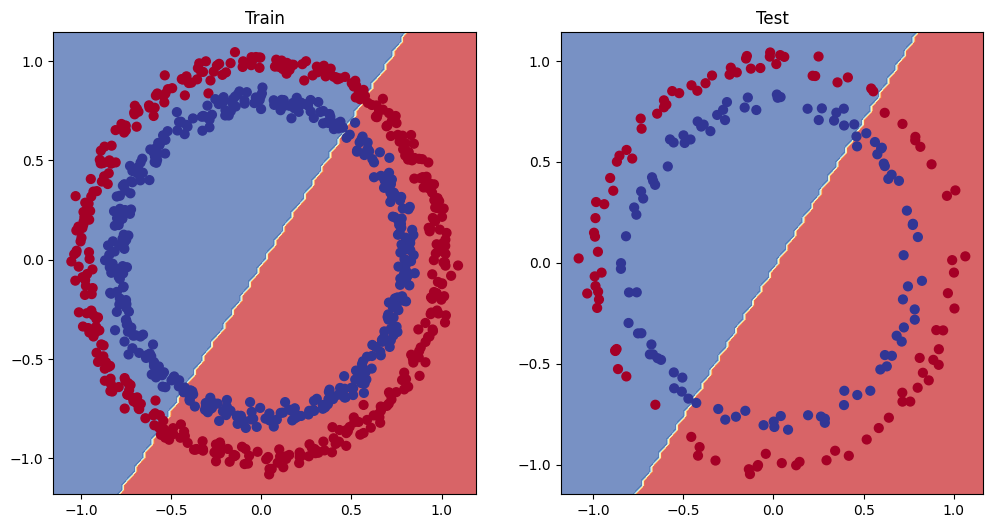

In [63]:
# Plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)


In [57]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

## 5 - skipped, bc not necessary
# 6 The missing piece: non-linearity
What patterns could you draw if you had a high amount of staight and non-straight lines? or linear and non linear functions
in doc 2